In [17]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
rcParams['figure.figsize'] = 15,6

In [3]:
data = pd.read_csv('../data/soy/13/soy_prices.csv')
data.head()

,id,product_id,main_location_id,date,avg_price,ask,bid,created_at,main_location,updated_at
0,1,2,13,2021-06-01,98.260000,100.930014,96.294925,2021-08-02 14:51:46,NaN,2023-08-29 19:11:02
1,16,2,13,2021-06-28,86.791109,NaN,NaN,2021-08-02 14:51:46,NaN,2023-08-29 19:11:02
2,110,2,13,2021-06-21,88.678023,NaN,NaN,2021-08-02 14:51:46,NaN,2023-08-29 19:11:02
3,127,2,13,2021-06-16,92.501266,97.651859,85.078293,2021-08-02 14:51:46,NaN,2023-08-29 19:11:02
4,135,2,13,2021-06-29,86.988890,92.104972,84.394537,2021-08-02 14:51:46,NaN,2023-08-29 19:11:02


In [4]:
def convert_df_price_type(data):
  data["avg_price"] = data["avg_price"].astype(str).str.replace(',', '.')
  return data
data = convert_df_price_type(data)

In [5]:
def separate_training_and_test_data(data):
  data_to_train = data[:175]
  data_to_test = data[175:]
  data_to_train.to_csv('train_data.csv')
  data_to_test.to_csv('test_data.csv')

separate_training_and_test_data(data)

In [6]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [7]:
def reshape_df(df):
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(df['avg_price'].values.reshape(-1,1))
  return scaled_data,scaler

scaled_data,scaler = reshape_df(test_data)

In [8]:
#how many days foward to predict
prediction_days = 1

def get_data_and_value_list(scaled_data,prediction_days):
  x_train=[]
  y_train=[]
  for x in range(prediction_days, len(scaled_data)):
      x_train.append(scaled_data[x-prediction_days:x, 0])
      y_train.append(scaled_data[x, 0])
  return x_train,y_train

In [9]:
x_train, y_train = get_data_and_value_list(scaled_data,prediction_days)

#reshape x_train
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
#Build the Model 4 LAYERS
def create_model_LSTM(x_train):
  model = Sequential()
  model.add(LSTM(units=75, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=75, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=75, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=75))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  model.summary()
  model.compile(optimizer='adam', loss='mean_squared_error')
  history = model.fit(x_train, y_train, epochs=200, batch_size=32)
  return model, history

model, history = create_model_LSTM(x_train)

c:\Users\gui_h\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 75)          │        23,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 75)          │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 75)          │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 75)             │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,076 (621.39 KB)

 Trainable params: 159,076 (621.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2834
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1606 
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0576 
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0376 
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 
Epoch 13/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 
Epoch 14/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 
Epoch 15/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

In [11]:
def get_model_inputs(train_data,test_data):
  total_dataset = pd.concat((train_data['avg_price'], test_data['avg_price']), axis=0)
  model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
  model_inputs = model_inputs.reshape(-1, 1)
  model_inputs = scaler.transform(model_inputs)
  return model_inputs

model_inputs = get_model_inputs(train_data,test_data)
actual_prices = test_data['avg_price'].values

C:\Users\gui_h\AppData\Local\Temp\ipykernel_11116\533843181.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values


In [21]:
# Make Predictions on Test Data
def make_predictions(prediction_days,model_inputs):
  x_test=[]
  for x in range(prediction_days, len(model_inputs)):
      x_test.append(model_inputs[x-prediction_days:x, 0])
  x_test=np.array(x_test)
  x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  predicted_prices=model.predict(x_test)
  predicted_prices=scaler.inverse_transform(predicted_prices)
  return predicted_prices,x_test

predicted_prices,x_test = make_predictions(prediction_days,model_inputs)
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error: {mse}")
mse = mean_squared_error([actual_prices[-1]], [predicted_prices[-1]])
print(f"Mean Squared Error: {mse}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error: 1.7876636394440015
Mean Squared Error: 0.5524581466206865


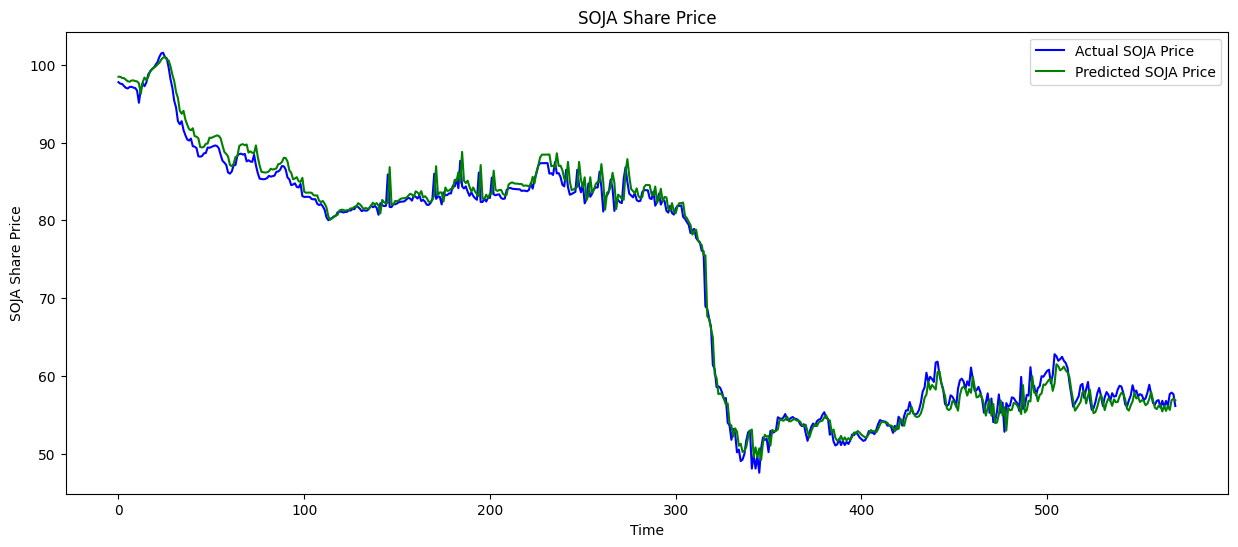

In [13]:
# Plot the test predictions
plt.plot(actual_prices, color = "blue", label=f"Actual SOJA Price")
plt.plot(predicted_prices, color="green", label=f"Predicted SOJA Price")
plt.title(f"SOJA Share Price")
plt.xlabel("Time")
plt.ylabel(f"SOJA Share Price")
plt.legend()
plt.show()

In [15]:
def predict_tomorrow(real_data):
  prediction = model.predict(real_data)
  #transformar valores de 0 a 1 para os valores reais
  prediction = scaler.inverse_transform(prediction)
  return prediction

#Predict Next Day
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs+prediction_days), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

In [20]:
prediction = predict_tomorrow(real_data)

print(f"Prediction: {prediction}")
print(f"Date prediction: ",data["date"].iloc[-1])
print(f"Last price",scaler.inverse_transform(x_test[-1]))
print(f"Date last price: ",data["date"].iloc[-2])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: [[55.581352]]
Date prediction:  2024-04-17
Last price [[57.6290775]]
Date last price:  2024-04-16
Mean Squared Error: 0.5524581466206865
